In [7]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45


from torch.autograd.functional import jacobian
import random



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


# Pendelum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [8]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.arange(0, 10, 0.01)

sol = odeint(pend,y0, t, args=(b,c))


In [9]:
theta = 2*np.pi - sol[:, 0]
omega = sol[:, 1]

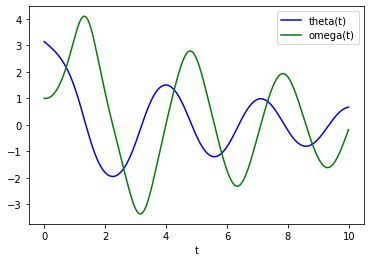

In [10]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

# Neural ODE with ajoint-sensitivity-method

In [11]:
def euler_forward_batch(func, x,t, propagation_time, delta_t, return_seq=False):
    time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
    x = x.clone().detach() 
    t = t.clone().detach()
    if not return_seq:
        for t in time:
            x = x + delta_t * func(x,t).flatten()
        return x
    if return_seq:
        outputs = []
        for t in time:
            x = x + delta_t * func(x,t).flatten()
            outputs.append(x)
        return torch.tensor(outputs)

In [12]:
class PendelumNetwork(nn.Module):
    def __init__(self):
        super(PendelumNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 1, dtype=float)
        )
    def forward(self,x,t): #f(x(t), t)
        input_ = torch.zeros(2,len(x), dtype=float)
        input_[0] = x
        input_[1] = t
        input_ = input_.T
        return self.linear_relu_stack(input_)

In [33]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, delta_t , x,t, propagation_time, return_seq=False):
        with torch.no_grad():
            if return_seq:
                return euler_forward_batch(func, x,t, propagation_time, delta_t, return_seq)
            else:
                output = euler_forward_batch(func, x,t, propagation_time, delta_t, return_seq)
                ctx.func = func
                ctx.delta_t = delta_t
                ctx.propagation_time = propagation_time
                ctx.save_for_backward(x.clone(),t.clone(),output.clone())
                return output
        
    
    @staticmethod
    def backward(ctx, dL_dz):

        func = ctx.func
        delta_t = ctx.delta_t
        propagation_time = ctx.propagation_time
        input_,x_1, t_0 = ctx.saved_tensors
        a_1 = dL_dz
        t_1 = t_0 + propagation_time

        def one_adjoint_backward_step(func, x_1, t_1, a_1, delta_t):
            a = a_1.clone().detach() 
            x = x_1.clone().detach()
            t = t_1.clone().detach()
            outputs = func(x,t)
            a -= delta_t * torch.autograd.grad(outputs=outputs, inputs=x, grad_outputs=a)
            return a

        def one_euler_backward_step(func,x_1,t_1,delta_t):
            x = x_1.clone().detach()
            t = t_1.clone().detach()
            x -= delta_t * func(x,t)
            return x

        def get_gradient_with_respect_to_params(func, x, t):
            x = x.clone().detach()
            t = t.clone().detach()
            func(x,t).mean().backward()
            grads = []
            for param in func.parameters():
                grads.append(param.grad.view(-1))
            grads = torch.cat(grads)
            return grads.flatten()

        def get_dL_dp(func, a_1, x_1, t_1, delta_t):
            time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
            a = a_1.clone().detach() 
            x = x_1.clone().detach()
            result = torch.zeros( (a @ get_gradient_with_respect_to_params(func, x,t_1)).shape)
            
            for t in time:
                result -= delta_t * a @ get_gradient_with_respect_to_params(func, x,t_1)
                a = one_adjoint_backward_step(func, x,t, a, delta_t)
                x = one_euler_backward_step(func, x,t, delta_t)
                t_1 -= propagation_time#go backward in time
            return result

        return get_dL_dp(func,a_1,x_1, t_1, delta_t), None, None, None, None, None

In [14]:
class NeuralODE(nn.Module):
    def __init__(self, func, delta_t):
        super(NeuralODE, self).__init__()
        self.func = func
        self.delta_t = delta_t
    
    def forward(self, x,t, propagation_time, return_seq=False):
        return ODEAdjoint.apply(self.func, self.delta_t, x,t, propagation_time, return_seq)
        

In [30]:

N = 200
diff_t = 25
propagation_time = t[diff_t]

x_i = []
t_i = []
x_f = []

data_set = torch.zeros((3,N), dtype=float)



while len(t_i) < N:

    index = int(random.uniform(0, len(t)))

    if t[index]+propagation_time > t[-1] or index+propagation_time >= len(theta):
        continue

    t_i.append(t[index]) 
    x_i.append(theta[index])
    x_f.append(theta[index+diff_t])

t_i = torch.tensor(t_i)
x_i = torch.tensor(x_i)
x_f = torch.tensor(x_f)

#data normalization

#x_i = x_i/np.pi
#x_f = x_f/np.pi


data_set[0] = t_i
data_set[1] = x_i
data_set[2] = x_f
print("propagation_time, ", propagation_time)
data_set = data_set.T
data_set[:5]

propagation_time,  0.25


tensor([[ 4.2000,  1.3950,  1.0055],
        [ 7.9200, -0.0665, -0.4931],
        [ 0.1100,  3.0320,  2.7592],
        [ 8.0400, -0.2857, -0.6443],
        [ 1.7800, -1.3997, -1.8317]], dtype=torch.float64)

In [16]:
def createBatches(data_set, batch_size):
    batches = []
    number_of_batches = int(len(data_set)/batch_size)
    for i in range(number_of_batches):
        batches.append(data_set[i*batch_size:(i+1)*batch_size].T)
    number_of_batches = len(batches)
    return batches[:int(number_of_batches*0.75)], batches[int(number_of_batches*0.75):]


In [17]:
train, test = createBatches(data_set, 64)

t_i, x_i, x_f = train[0]
x_i, t_i

(tensor([ 0.2829, -0.6360,  0.9808, -0.5614, -1.6816,  2.6688,  0.7534,  3.0220,
          2.9608, -1.6328, -1.5344, -0.4786, -1.0338, -0.4799,  0.9739, -0.1965,
          0.7286, -1.0889, -1.2989, -0.9820,  0.0607, -0.4565,  1.2427,  0.1449,
          1.3135, -0.7386,  0.8973,  2.8865, -0.7329, -0.7197,  0.0450, -1.9081,
         -1.0147,  1.5407, -0.2954, -0.2506, -0.4522, -0.4234, -1.7539,  0.8189,
          0.4826,  2.2138, -0.3516,  0.5006, -0.7700,  1.4868,  0.4081,  0.6529,
          0.6315,  0.0053, -0.8787, -1.7975, -0.5216,  0.6994,  0.4319, -0.4741,
         -1.0147,  0.6823, -1.7403,  1.2417,  2.5068,  0.9781, -0.5872, -1.3753],
        dtype=torch.float64),
 tensor([4.7400, 8.9100, 7.0900, 8.2200, 2.5900, 0.4300, 7.4500, 0.1200, 0.1800,
         2.6200, 1.8400, 8.1600, 5.8600, 9.0400, 7.1700, 9.2300, 6.7600, 5.8100,
         1.7400, 5.2800, 4.8200, 3.0700, 1.0500, 7.8100, 4.2700, 6.0500, 4.5000,
         0.2500, 8.8000, 6.0600, 3.2200, 2.3800, 2.8900, 0.9600, 6.2600, 8.020

In [40]:
#training
epoch = 500
delta_t = 0.01

func = PendelumNetwork()
model = NeuralODE(func, delta_t)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for k in range(epoch):
    avg_los = 0
    for train_batch in train:
        t_i, x_i, real_value = train_batch
        prediction = model(x_i, t_i, propagation_time).requires_grad_(True)
        loss = 1/2 * (prediction - real_value)@(prediction - real_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_los += loss.item()
    if k%10==0:
        avg_los_2 = 0
        for test_batch in test:
            t_i, x_i, real_value = test_batch
            prediction_ = model(x_i, t_i, propagation_time)
            loss_ = 1/2 * (prediction - real_value)@(prediction - real_value)
            avg_los_2 += loss_.item()

        avg_los = avg_los/64
        avg_los_2 = avg_los_2/64
        print(k , "\t training ",avg_los)
        print(" \t validation ",avg_los_2)
        print("_________")


0 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
10 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
20 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
30 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
40 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
50 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
60 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
70 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
80 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
90 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
100 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
110 	 training  0.27047576057112976
 	 validation  1.565708317887554
_________
120 	 training  0.27047576057112976
 	 validation  1.5657083178

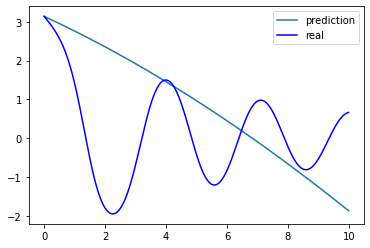

In [41]:
prediction = model(torch.tensor([np.pi],dtype=float), torch.tensor(0), 10, True)
plt.plot(np.arange(0, 10, delta_t),prediction, label="prediction")
plt.plot(t, theta, color='b',label="real")
plt.legend()
plt.show()